In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import itertools
warnings.filterwarnings("ignore")
import statsmodels.api as sm
import matplotlib

In [5]:
# importing predict-demand data 
data=pd.read_csv("train.csv")

In [6]:
data.head()

,id,date,city,lat,long,pop,shop,brand,container,capacity,price,quantity
0,0.0,31/01/12,Athens,37.97945,23.71622,672130.0,shop_1,kinder-cola,glass,500ml,0.96,13280.0
1,1.0,31/01/12,Athens,37.97945,23.71622,672130.0,shop_1,kinder-cola,plastic,1.5lt,2.86,6727.0
2,2.0,31/01/12,Athens,37.97945,23.71622,672130.0,shop_1,kinder-cola,can,330ml,0.87,9848.0
3,3.0,31/01/12,Athens,37.97945,23.71622,672130.0,shop_1,adult-cola,glass,500ml,1.00,20050.0
4,4.0,31/01/12,Athens,37.97945,23.71622,672130.0,shop_1,adult-cola,can,330ml,0.39,25696.0


In [7]:
# converting column 'date' into pandas date-time format 
data['date'] = pd.to_datetime(data['date'])

In [8]:
# Our target variable is 'quantity'. Removing irrelevant columns.
cols=['id', 'city', 'lat', 'long', 'pop', 'shop', 'brand','container', 'capacity', 'price']
data.drop(cols,axis=1,inplace=True)

### Data Pre-processing

In [9]:
# checking for missing values
data.isna().sum()
# there are missing values

date        1080
quantity    1080
dtype: int64

In [10]:
# Removing the rows with missing values
data.dropna(axis=0,inplace=True)

In [11]:
data.isna().sum()

date        0
quantity    0
dtype: int64

In [12]:
data.shape

(6480, 2)

### Analysis and Visualization on Time Series Data

In [13]:
# Resample the data by combining month-wise samples together 
month_data=data.resample('M',on='date').sum()

In [14]:
y=month_data

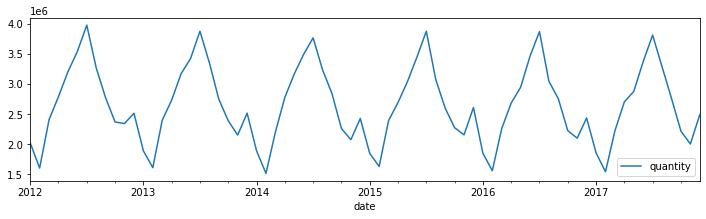

In [15]:
y.plot(figsize=(12,3))
plt.show()
# From the figure, we can observe seasonality in the data as the target variabele's variation with date-time shows a similar
# pattern that repeats in almost same interval of time.

In [16]:
# Analyse the different conmponents of time-series data - seasonal,trend,residual 
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_data = seasonal_decompose(y, model="additive")
#decompose_data.plot();

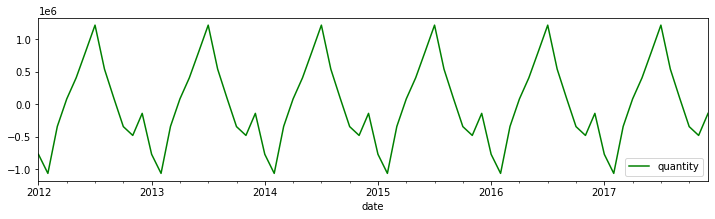

In [17]:
# Seasonality 
seasonality=decompose_data.seasonal
seasonality.plot(figsize=(12,3),color='green')
plt.show()

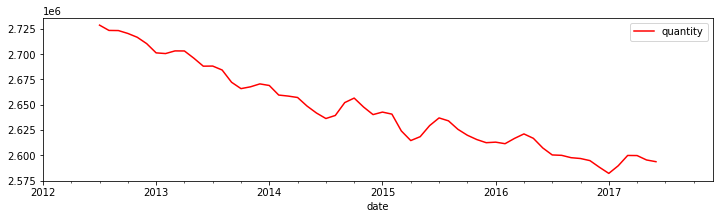

In [18]:
# Trend
trend_=decompose_data.trend
trend_.plot(figsize=(12,3),color='red')
plt.show()

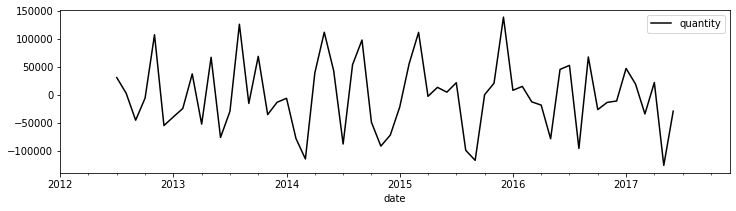

In [19]:
# Residual
res_=decompose_data.resid
res_.plot(figsize=(12,3),color='black')
plt.show()

In [20]:
# From these visualizations we can observe that our data shows high variations with time. 
# This indicates the non-stationarity nature of data. For getting more understanding on the stationarity of data,
# we can perform the ADfuller test, which is hypothesis test. 

In [21]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(y.quantity, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -1.6871355245159256
2. P-Value :  0.4377525325135515
3. Num Of Lags :  11
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 60
5. Critical Values :
	 1% :  -3.5443688564814813
	 5% :  -2.9110731481481484
	 10% :  -2.5931902777777776


In [22]:
# For the data to be a stationary, p-value should be less than 0.05. Here p-value is higher, hence the data is non-stationary.  
# To perform forecasting with ARIMA model, the data should be stationary. Here, as our data shows Seasonality and Non-stationary
# nature, we can go for SARIMAX model which includes seasonal effects and eXogenous factors with the autoregressive 
# and moving average component in the model. 

### Time Series Forecasting using SARIMAX Model

In [23]:
# Resampling the data by combining day-wise samples 
day_data=data.resample('D',on='date').sum()

In [24]:
# Only a portion of the data is taken for processing in order to reduce the training time.
total=day_data[1066:]
train_data=day_data[1066:1797]
test_data=day_data[1797:] 

In [26]:
# function to find the best combination of parameters for the model
def best_parameters(y):
    
    # Parameters for ARIMA model
    p=d=q=range(0, 2)
    
    # Creating all posssible combinations of Seasonal ARIMA
    pdq=list(itertools.product(p,d,q))
    seasonal_pdq=[(x[0],x[1],x[2],12) for x in list(itertools.product(p, d, q))]
    minAIC=100000000
    b_pdq=(0,0,0)
    b_spdq=(0,0,0)
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
                results = mod.fit()
                # Finding minimum value of AIC and Parameters corresponding minimum AIC value
                if results.aic<minAIC:
                    minAIC=results.aic
                    #print(results.aic)
                    b_pdq=param
                    b_spdq=param_seasonal
            except:
                continue
                
    print("best parameters: ",b_pdq)
    print("best seasonal parameters :",b_spdq)
    print("minimum aic value",minAIC)
    return b_pdq,b_spdq

In [27]:
best_p,best_sp = best_parameters(train_data)

best parameters:  (0, 0, 0)
best seasonal parameters : (1, 1, 1, 12)
minimum aic value 20577.95823627044


In [28]:
# Creating ARIMA model 
model=sm.tsa.statespace.SARIMAX(train_data,order=best_p,seasonal_order=best_sp,enforce_stationarity=False,enforce_invertibility=False)
ts_model=model.fit()

In [29]:
#Frecasting data for next 365 days
test_data['predicted'] = ts_model.forecast(steps=365)

In [30]:
test_data

,quantity,predicted
date,,
2017-01-01,0.0,54789.301812
2017-01-02,0.0,52993.897380
2017-01-03,0.0,40160.318148
2017-01-04,0.0,53274.543920
2017-01-05,0.0,42550.227960
...,...,...
2017-12-27,0.0,53888.183790
2017-12-28,0.0,52122.308322
2017-12-29,0.0,39499.802587


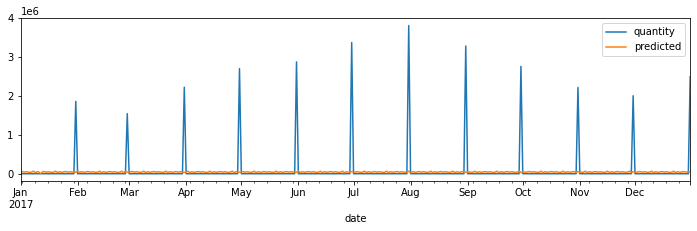

In [31]:
test_data[['quantity','predicted']].plot(figsize=(12,3))

In [32]:
pred=test_data['predicted']
actual=test_data['quantity']

In [33]:
# Root Mean Square Calculation
def rmse_calc(pred,actual):
    mse = ((pred - actual) ** 2).mean()
    rmse=np.sqrt(mse)
    print("RMSE : ",rmse)
    return rmse

In [35]:
rmse_val=rmse_calc(pred,actual)

RMSE :  479177.9257412871


### Evaluating the Model using Nested Cross Validation

In [36]:
train_data=day_data[1066:1797]
test_data=day_data[1797:] 

In [37]:
from cv import *

ERROR:root:Error disabling cv.imshow().
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/google/colab/_import_hooks/_cv2.py", line 86, in load_module
    cv_module.imshow,
AttributeError: module 'cv' has no attribute 'imshow'


In [38]:
k = len(train_data)-1
ncv = NestedCV(k)
splits = ncv.split(train_data,"date")

In [39]:
warnings.filterwarnings("ignore")
count=0
RMSE_history={}
Best_Params={}
for train,validate in splits:
    print("NO OF ITERATION:",count+1)
    best_param,best_seasonal = best_parameters(train)        # Hyper parameter tuning
    model=sm.tsa.statespace.SARIMAX(train,order=best_param,seasonal_order=best_seasonal,enforce_stationarity=False,enforce_invertibility=False)
    SARIMAX_model=model.fit()
    forecast = SARIMAX_model.forecast()[0]
    RMSE_history[count+1]=rmse_calc(forecast,validate.values)
    Best_Params[count+1]=best_param,best_seasonal
    count+=1

NO OF ITERATION: 1
best parameters:  (0, 0, 0)
best seasonal parameters : (0, 0, 0, 12)
minimum aic value 2.0
RMSE :  0.0
NO OF ITERATION: 2
best parameters:  (0, 0, 0)
best seasonal parameters : (0, 0, 0, 12)
minimum aic value -23.979843443775167
RMSE :  0.0
NO OF ITERATION: 3
best parameters:  (0, 0, 0)
best seasonal parameters : (0, 0, 0, 12)
minimum aic value -49.959686887550404
RMSE :  0.0
NO OF ITERATION: 4
best parameters:  (0, 0, 0)
best seasonal parameters : (0, 0, 0, 12)
minimum aic value -75.93953033132566
RMSE :  0.0
NO OF ITERATION: 5
best parameters:  (0, 0, 0)
best seasonal parameters : (0, 0, 0, 12)
minimum aic value -101.91937377510055
RMSE :  0.0
NO OF ITERATION: 6
best parameters:  (0, 0, 0)
best seasonal parameters : (0, 0, 0, 12)
minimum aic value -127.89921721887595
RMSE :  0.0
NO OF ITERATION: 7
best parameters:  (0, 0, 0)
best seasonal parameters : (0, 0, 0, 12)
minimum aic value -153.87906066265117
RMSE :  0.0
NO OF ITERATION: 8
best parameters:  (0, 0, 0)
best

In [40]:
# Mean RMSE of Nested Cross Validation
final_mean=sum(RMSE_history.values())/k    
print("mean RMSE value :",final_mean)    

mean RMSE value : 133662.49308039132


In [46]:
# Best Parameter
RMSE_history.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 22

In [57]:
results=pd.DataFrame()
results['parameters']=Best_Params.values()
results['RMSE']=RMSE_history.values()

In [61]:
results.groupby(['parameters'])['RMSE'].mean()
#This shows average error is less for parameters - ((0, 0, 1), (1, 1, 1, 12))

parameters
((0, 0, 0), (0, 0, 0, 12))    6.169640e+04
((0, 0, 0), (1, 1, 1, 12))    1.230505e+05
((0, 0, 1), (0, 1, 1, 12))    5.617503e+04
((0, 0, 1), (1, 1, 1, 12))    2.715740e+00
((0, 1, 1), (0, 1, 1, 12))    1.663438e+05
((0, 1, 1), (1, 1, 1, 12))    3.734674e+04
((1, 1, 0), (1, 1, 0, 12))    1.850892e+06
((1, 1, 1), (0, 1, 1, 12))    3.490565e+04
((1, 1, 1), (1, 1, 0, 12))    2.530278e+05
Name: RMSE, dtype: float64

In [63]:
results.groupby(['parameters']).count()

,RMSE
parameters,
"((0, 0, 0), (0, 0, 0, 12))",30
"((0, 0, 0), (1, 1, 1, 12))",389
"((0, 0, 1), (0, 1, 1, 12))",53
"((0, 0, 1), (1, 1, 1, 12))",3
"((0, 1, 1), (0, 1, 1, 12))",230
"((0, 1, 1), (1, 1, 1, 12))",2
"((1, 1, 0), (1, 1, 0, 12))",1
"((1, 1, 1), (0, 1, 1, 12))",4
"((1, 1, 1), (1, 1, 0, 12))",18


In [ ]:
# Errors in descending order with number of times used 
# 1st least error = ((0, 0, 1), (1, 1, 1, 12)) - 3 times used
# 2nd least error = ((1, 1, 1), (0, 1, 1, 12)) - 4 
# 3rd least error = ((0, 1, 1), (1, 1, 1, 12)) - 2 
# 4th least error = ((0, 0, 1), (0, 1, 1, 12)) - 53
# 5th least error = ((0, 0, 0), (0, 0, 0, 12)) - 30
# 6th least error = ((0, 0, 0), (1, 1, 1, 12)) - 389
# 7th least error = ((0, 1, 1), (0, 1, 1, 12)) - 230
# 8th least error = ((1, 1, 1), (1, 1, 0, 12)) - 18
# 9th least error = ((1, 1, 0), (1, 1, 0, 12)) - 1

In [73]:
# create the model using the best parameters 
best_p=(0, 0, 1)
best_sp=(1, 1, 1, 12)
model=sm.tsa.statespace.SARIMAX(train_data,order=best_p,seasonal_order=best_sp,enforce_stationarity=False,enforce_invertibility=False)
ts_model=model.fit()

In [74]:
test_data['predicted'] = ts_model.forecast(steps=365)
#test_data

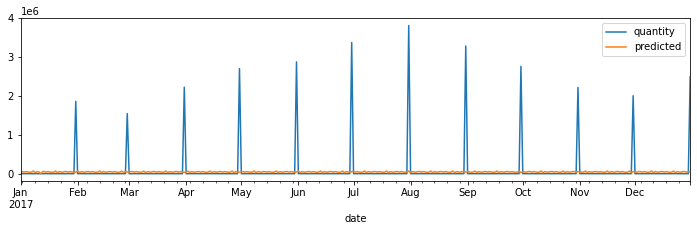

In [75]:
test_data[['quantity','predicted']].plot(figsize=(12,3))

In [76]:
pred=test_data['predicted']
actual=test_data['quantity']

In [77]:
rmse_=rmse_calc(pred,actual)

RMSE :  479066.19008953916


In [ ]:
# Observations : 

# 1. A slight reduction in error is observed when we tested the model. This indicates nested cross validation can be 
#    used to select better hyperparameters that improves model performance.
# 2. In nested ross validation mean RMSE value calculated is 133662.49308039132. This is less compared to the mean 
#    testing errors (479066.19008953916). This shows the model performance can be improved by training with more data.